In [ ]:
import os
import numpy as np
import cv2  

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dropout, Reshape, Multiply, Permute, Flatten, Activation, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from sklearn.model_selection import train_test_split
import shutil

In [26]:
import warnings
warnings.filterwarnings('ignore')

# Load data and create data generators

In [2]:
train_dir = os.path.join('./data/cats_and_dogs/', 'train')
test_dir = os.path.join('./data/cats_and_dogs/', 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Attention Model

In [23]:
class SoftSpatialAttention(layers.Layer):
    def __init__(self):
        super(SoftSpatialAttention, self).__init__()

    def build(self, input_shape):
        self.conv2d_1 = Conv2D(filters=1, kernel_size=(1, 1), input_shape=input_shape, activation='sigmoid')
        self.conv2d_2 = Conv2D(filters=1, kernel_size=(1, 1), input_shape=input_shape, activation='sigmoid')
        self.reshape_1 = Reshape((-1,))
        self.activation = Activation('softmax', name='attentio_weights')
        self.reshape_2 = Reshape((input_shape[1], input_shape[2], 1)) 
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.conv2d_2(x)
        x = self.reshape_1(x)
        x = self.activation(x)
        x = self.reshape_2(x)

        out = self.multiply([x, inputs])

        return out

In [24]:
inputs = tf.keras.Input(shape=(150, 150, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = Dropout(0.1)(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = Dropout(0.1)(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = SoftSpatialAttention()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

X = tf.keras.layers.Dense(512, activation='relu')(x) 

outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 36, 36, 64)        0     

In [28]:
model.fit(train_generator, epochs=30, verbose=1)

Epoch 1/30
625/625 [==============================] - 212s 338ms/step - loss: 0.6219 - accuracy: 0.6544
Epoch 2/30
625/625 [==============================] - 200s 320ms/step - loss: 0.6033 - accuracy: 0.6750
Epoch 3/30
625/625 [==============================] - 201s 322ms/step - loss: 0.5887 - accuracy: 0.6915
Epoch 4/30
625/625 [==============================] - 202s 323ms/step - loss: 0.5791 - accuracy: 0.6977
Epoch 5/30
625/625 [==============================] - 200s 320ms/step - loss: 0.5682 - accuracy: 0.7093
Epoch 6/30
625/625 [==============================] - 200s 319ms/step - loss: 0.5554 - accuracy: 0.7233
Epoch 7/30
625/625 [==============================] - 199s 318ms/step - loss: 0.5364 - accuracy: 0.7341
Epoch 8/30
625/625 [==============================] - 204s 327ms/step - loss: 0.5277 - accuracy: 0.7420
Epoch 9/30
625/625 [==============================] - 197s 316ms/step - loss: 0.5177 - accuracy: 0.7503
Epoch 10/30
625/625 [==============================] - 200s 320m

In [29]:
model.evaluate(test_generator)

157/157 [==============================] - 57s 364ms/step - loss: 0.2404 - accuracy: 0.9000


[0.24041655659675598, 0.8999999761581421]

## Extracting attention layer

In [39]:
model.layers[11]

In [49]:
attention = tf.keras.Model(inputs=model.inputs, outputs=[model.outputs[0], model.layers[11].output])
attention.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 36, 36, 64)        0   

In [50]:
sample = next(train_generator)
pred, weights = attention.predict(sample[0])
print(weights[0].shape)

1/1 [==============================] - 0s 239ms/step
(7, 7, 128)


In [107]:
def visualize_attention():
    original_img = next(train_generator)
    print(original_img[0][0].shape)
    pred, attention_weights = attention.predict(original_img[0])
    print(attention_weights[0].shape)
    
    attention_weights = cv2.resize(attention_weights[0], (150, 150))
    #print(attention_weights.shape)
 
    plt.imshow(original_img[0][0])  # Display the input image
    plt.show()
    plt.imshow(original_img[0][0])  # Display the input image
    plt.imshow(attention_weights[..., 2], cmap='jet', alpha=0.4)  # Overlay the attention weights
    plt.colorbar()
    plt.show()

(150, 150, 3)
1/1 [==============================] - 0s 118ms/step
(7, 7, 128)


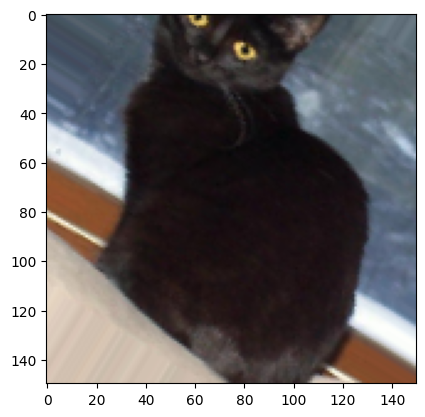

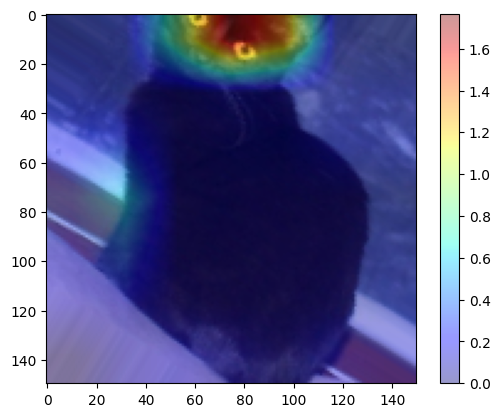

In [112]:
visualize_attention()

1/1 [==============================] - 0s 121ms/step
(32, 1)


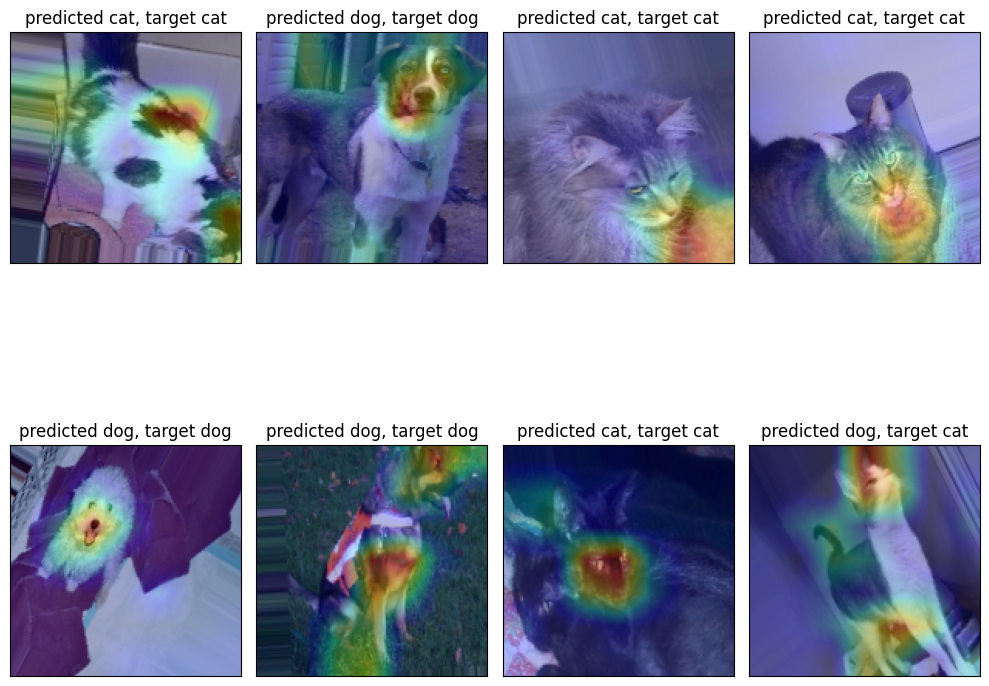

In [116]:
imgs, targets = next(train_generator)
preds, attention_weights = attention.predict(imgs)

print(preds.shape)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10,10))
axs = axs.ravel()

for i in range(8):
    resized_attention_weights = cv2.resize(attention_weights[i, ..., 2], (imgs[i].shape[1], imgs[i].shape[1]))

    pred = 'dog' if np.round(preds[i]) == 1 else 'cat'
    target = 'dog' if targets[i] == 1 else 'cat'

    axs[i].imshow(imgs[i])  
    axs[i].imshow(resized_attention_weights, cmap='jet', alpha=0.3) 
    axs[i].title.set_text(f'predicted {pred}, target {target}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.tight_layout()